### Import Libraries

In [20]:
import h5py
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

### Load Data

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"
cube = h5py.File(CUBE_PATH, "r")

spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")

### Process Data

In [3]:
sfrs_notna = sfrs.loc[sfrs["FLAG"] == 0.0].copy()
metadata_indices = metadata[:, 0]["ds_slice_idx"]
common_indices = np.intersect1d(metadata_indices, sfrs_notna.index.values)
idx_spectra = np.isin(metadata_indices, common_indices)
X_spectra = spectra[idx_spectra]

In [4]:
nan_rows = np.isnan(X_spectra).any(axis=1)
nan_removed = np.sum(nan_rows)
X_spectra = X_spectra[~nan_rows]

In [5]:
def simplify_targettype(value):
    value = value.decode("utf-8").strip()
    if "GALAXY" in value:
        return "GALAXY"
    elif "QSO" in value or "QA" in value:
        return "QUASAR"
    elif "STAR" in value:
        return "STAR"
    else:
        return "OTHER" 

In [6]:
sfrs_z_filtered = sfrs_notna.loc[sfrs_notna["Z"].notna()].copy()
z_retained = len(sfrs_z_filtered)
z_removed = len(sfrs) - z_retained

In [7]:
sfrs_z_filtered.loc[:, "Simplified_TARGETTYPE"] = sfrs_z_filtered["TARGETTYPE"].apply(simplify_targettype)
sfrs_z_filtered = sfrs_z_filtered[[sca"Simplified_TARGETTYPE", "Z"]]
Y = sfrs_z_filtered.loc[metadata_indices[idx_spectra], "Simplified_TARGETTYPE"].values
Y = Y[~nan_rows]

In [8]:
n_samples = len(common_indices)
X_images = images[:n_samples].reshape(n_samples, -1)
nan_rows_images = np.isnan(X_images).any(axis=1)

X_images_final = X_images[~nan_rows_images]
Y_images_final = Y[:X_images_final.shape[0]]

print(f"Final X_images shape: {X_images_final.shape}")
print(f"Final Y_images shape: {Y_images_final.shape}")

Final X_images shape: (16830, 20480)
Final Y_images shape: (11179,)


In [9]:
label_encoder = LabelEncoder()
Y_images_final = label_encoder.fit_transform(Y_images_final)

# Images
### Process Image Data

In [10]:
n_samples_labels = Y_images_final.shape[0]
X_images = images[:n_samples_labels]  

nan_rows_images = np.isnan(X_images).any(axis=(1, 2, 3)) 

X_images_filtered = X_images[~nan_rows_images]
Y_images_filtered = Y_images_final[~nan_rows_images]

print(f"Filtered X_images shape: {X_images_filtered.shape}")
print(f"Filtered Y_images shape: {Y_images_filtered.shape}")

Filtered X_images shape: (11169, 5, 64, 64)
Filtered Y_images shape: (11169,)


In [11]:
redshifts = sfrs_z_filtered.loc[metadata_indices[idx_spectra], "Z"].values
redshifts = redshifts[~nan_rows]
filters = ["u", "g", "r", "i", "z"]

In [12]:
def normalize_spectra(spectra):
    min_val = np.min(spectra, axis=1, keepdims=True)
    max_val = np.max(spectra, axis=1, keepdims=True)
    
    return 2 * (spectra - min_val) / (max_val - min_val) - 1

X_spectra_normalized = normalize_spectra(X_spectra)

# Machine Learning for Z

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_spectra_normalized, redshifts, test_size=0.2, random_state=42
)

In [15]:
model = DecisionTreeRegressor(max_depth=100, random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=100, random_state=42)

In [16]:
y_pred = model.predict(X_test)

In [17]:
pd.DataFrame(y_test)

,0
0,0.049449
1,0.223478
2,0.068231
3,0.056101
4,0.111342
...,...
2231,0.160708
2232,0.251732
2233,0.030295
2234,0.277786


In [18]:
pd.DataFrame(y_pred)

,0
0,0.141128
1,0.225984
2,0.160077
3,0.060701
4,0.202809
...,...
2231,0.142444
2232,0.290511
2233,0.130493
2234,0.107591


In [22]:
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.0593


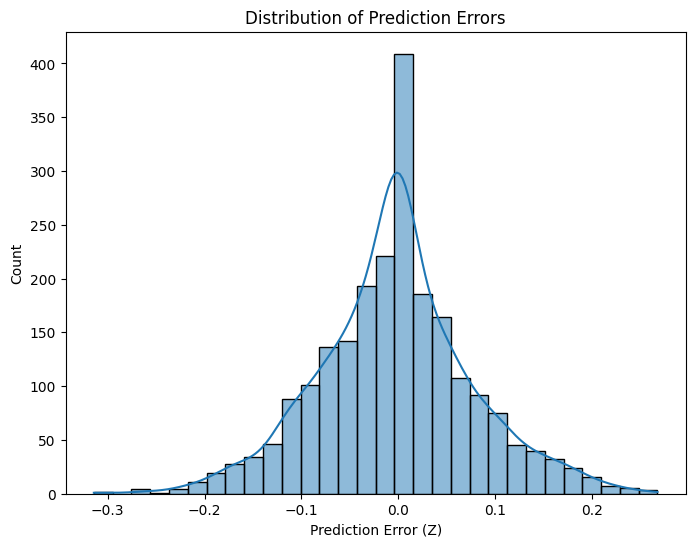

In [23]:
errors = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel("Prediction Error (Z)")
plt.ylabel("Count")
plt.title("Distribution of Prediction Errors")
plt.show()

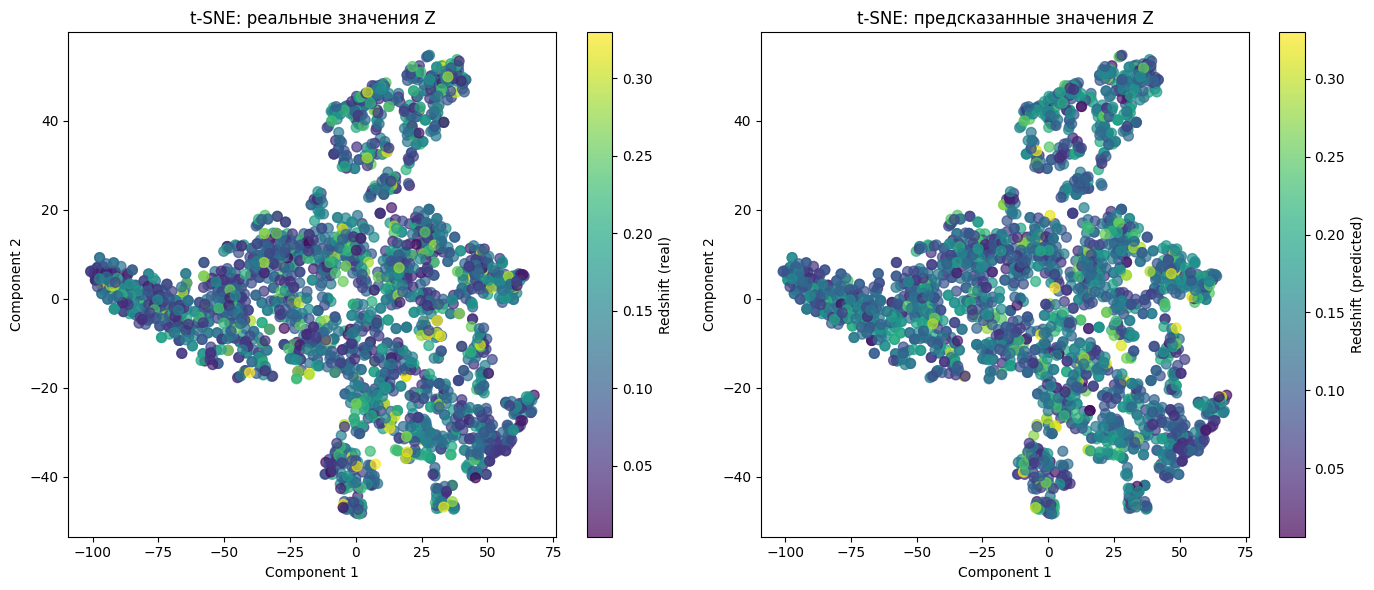

In [30]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_test_tsne = tsne.fit_transform(X_test)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sc1 = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap="viridis", s=50, alpha=0.7)
plt.title("t-SNE: реальные значения Z", fontsize=12)
plt.xlabel("Component 1", fontsize=10)
plt.ylabel("Component 2", fontsize=10)
plt.colorbar(sc1, label="Redshift (real)")

plt.subplot(1, 2, 2)
sc2 = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_pred, cmap="viridis", s=50, alpha=0.7)
plt.title("t-SNE: предсказанные значения Z", fontsize=12)
plt.xlabel("Component 1", fontsize=10)
plt.ylabel("Component 2", fontsize=10)
plt.colorbar(sc2, label="Redshift (predicted)")

plt.tight_layout()
plt.show()

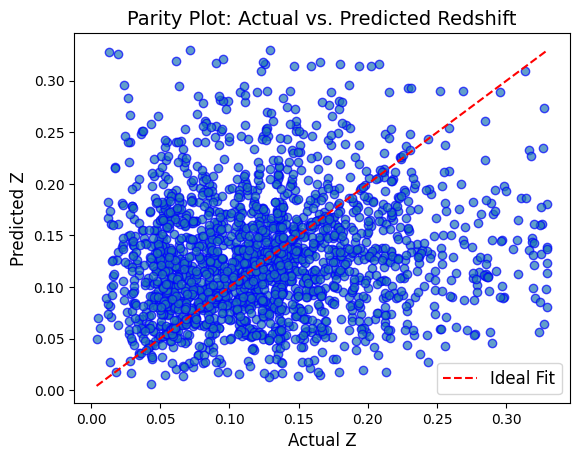

In [34]:
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='b') 
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("Actual Z", fontsize=12)   
plt.ylabel("Predicted Z", fontsize=12)    
plt.title("Parity Plot: Actual vs. Predicted Redshift", fontsize=14) 
plt.legend(fontsize=12)               
plt.show()                              

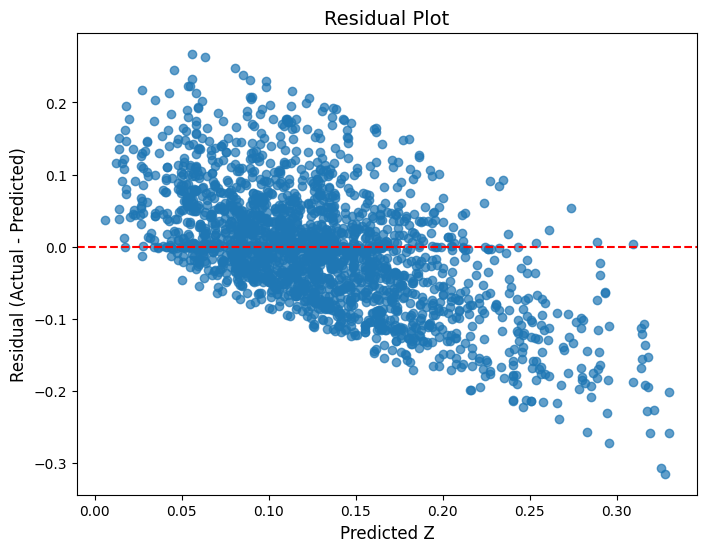

In [35]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7) 
plt.axhline(y=0, color='red', linestyle='--') 
plt.xlabel("Predicted Z", fontsize=12)     
plt.ylabel("Residual (Actual - Predicted)", fontsize=12)  
plt.title("Residual Plot", fontsize=14)     
plt.show()                                 


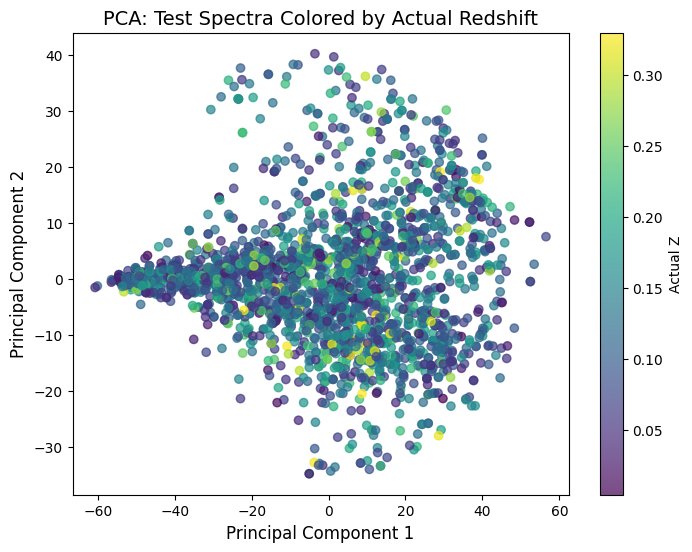

In [36]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test) 

plt.figure(figsize=(8, 6))
sc = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.xlabel("Principal Component 1", fontsize=12) 
plt.ylabel("Principal Component 2", fontsize=12) 
plt.title("PCA: Test Spectra Colored by Actual Redshift", fontsize=14) 
plt.colorbar(sc, label="Actual Z")             
plt.show()                         

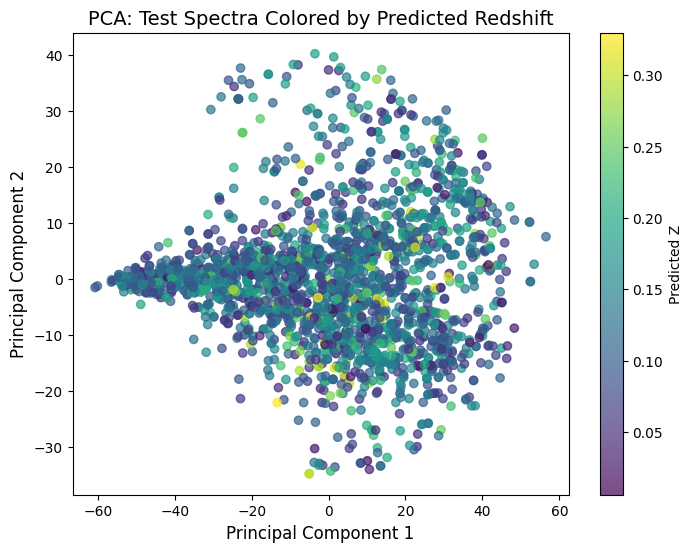

In [37]:
plt.figure(figsize=(8, 6))

sc = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
plt.xlabel("Principal Component 1", fontsize=12)  
plt.ylabel("Principal Component 2", fontsize=12)
plt.title("PCA: Test Spectra Colored by Predicted Redshift", fontsize=14) 
plt.colorbar(sc, label="Predicted Z")          
plt.show() 

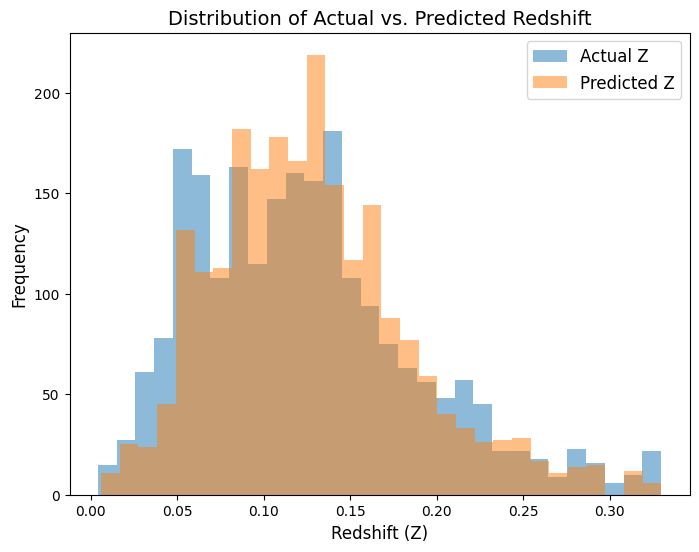

In [38]:
plt.figure(figsize=(8, 6))
plt.hist(y_test, bins=30, alpha=0.5, label="Actual Z")     
plt.hist(y_pred, bins=30, alpha=0.5, label="Predicted Z")   
plt.xlabel("Redshift (Z)", fontsize=12)  
plt.ylabel("Frequency", fontsize=12) 
plt.title("Distribution of Actual vs. Predicted Redshift", fontsize=14)  
plt.legend(fontsize=12)                  
plt.show()                                

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_spectra_normalized,
    redshifts,
    cv=5,
    scoring='neg_mean_absolute_error', 
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42 
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation Error")
plt.xlabel("Number of Training Samples", fontsize=12)
plt.ylabel("Mean Absolute Error", fontsize=12)        
plt.title("Learning Curve", fontsize=14)         
plt.legend(fontsize=12)                                
plt.show()                                   